In [ ]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from ekyn import SleepStageClassifier
import numpy as np
from sklearn.metrics import f1_score

device = 'cuda'
conditions = ['PF','Vehicle']
path_to_pt_ekyn = f'../pt_ekyn'
path_to_pt_snezana_mice = f'../pt_snezana_mice'
colors = {
    'train': '#007AFF',
    'test': '#FF9500'
}
ekyn_ids = sorted(set([recording_filename.split('_')[0] for recording_filename in os.listdir(path_to_pt_ekyn)]))
snezana_mice_ids = sorted(set([recording_filename.split('.')[0] for recording_filename in os.listdir(path_to_pt_snezana_mice)]))
print(len(ekyn_ids),ekyn_ids)
print(len(snezana_mice_ids),snezana_mice_ids)

def load_ekyn(id,condition):
    X,y = torch.load(f'{path_to_pt_ekyn}/{id}_{condition}.pt',weights_only=False)
    return X,y
def load_snezana_mice(id):
    X,y = torch.load(f'{path_to_pt_snezana_mice}/{id}.pt',weights_only=False)
    return X,y
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size
def moving_average(data, window_size):
    """Calculate moving average with specified window size."""
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, id, condition='PF', dataset='ekyn'):
        if dataset == 'ekyn':
            self.X,self.y = load_ekyn(id=id,condition=condition)
        elif dataset == 'mice':
            self.X,self.y = load_snezana_mice(id=id)
            
        mean = self.X.flatten().mean()
        std = self.X.flatten().std()
        self.X = (self.X - mean) / (std + 1e-5)
        self.X = self.X[:,::10]
        self.X = self.X.unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

def get_dataloader(ekyn_ids,snezana_mice_ids,batch_size,shuffle):
    return DataLoader(
        dataset=ConcatDataset(
            [
                EEGDataset(id=id,condition=condition,dataset='ekyn') for id in ekyn_ids for condition in conditions
            ]
            +
            [
                EEGDataset(id=id,dataset='mice') for id in snezana_mice_ids
            ]
                    ),
        batch_size=batch_size,
        shuffle=shuffle)
class SimpleAdaptiveNorm(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable affine parameters
        self.scale = nn.Parameter(torch.ones(1))
        self.shift = nn.Parameter(torch.zeros(1))
        
        # Small network for signal-dependent adjustment
        self.adaptation_net = nn.Sequential(
            nn.Linear(4, 8),  # Input: mean, std, min, max of each sample
            nn.ReLU(),
            nn.Linear(8, 2)   # Output: additional scale and shift
        )
        
    def forward(self, x):
        # Extract more complex statistics than just mean and std
        mean = x.mean(dim=2, keepdim=False)
        std = x.std(dim=2, keepdim=False)
        max_val = x.max(dim=2)[0]
        min_val = x.min(dim=2)[0]
        
        # Combine statistics for a richer representation
        stats = torch.stack([mean, std, max_val, min_val], dim=1).squeeze()
        # Get adaptive adjustments
        adjustments = self.adaptation_net(stats)
        adaptive_scale = adjustments[:, 0].view(-1, 1, 1)
        adaptive_shift = adjustments[:, 1].view(-1, 1, 1)
        
        # Apply learnable parameters plus adaptive adjustments
        return x * (self.scale + adaptive_scale) + (self.shift + adaptive_shift)
class SleepStageClassifier(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.adaptive_norm = SimpleAdaptiveNorm()
        self.stem = nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3) for _ in range(3)])
        self.gap = nn.AdaptiveAvgPool1d(output_size=1)
        self.fc1 = nn.Linear(in_features=64,out_features=32)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=32,out_features=3)
    def forward(self,x):
        x = self.adaptive_norm(x)
        x = self.stem(x)
        x = nn.functional.relu(x)
        for conv in self.convs:
            x = conv(x)
            x = nn.functional.relu(x)
        x = self.gap(x)
        x = x.flatten(1,2)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

In [ ]:
import torch
batch_size = 1024
ekyn_ids = ekyn_ids[:16] # tmp
snezana_mice_ids = snezana_mice_ids[:16] # tmp

train_ekyn_ids,test_ekyn_ids = ekyn_ids[:-len(ekyn_ids)//4],ekyn_ids[-len(ekyn_ids)//4:]
print(len(train_ekyn_ids),len(test_ekyn_ids),train_ekyn_ids,test_ekyn_ids)
train_snezana_mice_ids,test_snezana_mice_ids = snezana_mice_ids[:-len(snezana_mice_ids)//4],snezana_mice_ids[-len(snezana_mice_ids)//4:]
print(len(train_snezana_mice_ids),len(test_snezana_mice_ids),train_snezana_mice_ids,test_snezana_mice_ids)

trainloader = get_dataloader(train_ekyn_ids,train_snezana_mice_ids,batch_size,shuffle=True)
testloader = get_dataloader(test_ekyn_ids,test_snezana_mice_ids,batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SleepStageClassifier()
model.eval()
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('best_model_by_f1.pt',weights_only=True))
model.to(device)

              precision    recall  f1-score   support

           0       0.73      0.67      0.70     23330
           1       0.93      0.94      0.93    219048
           2       0.93      0.92      0.93    276022

    accuracy                           0.92    518400
   macro avg       0.86      0.85      0.85    518400
weighted avg       0.92      0.92      0.92    518400

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      8356
           1       0.94      0.92      0.93     85806
           2       0.91      0.92      0.91     95918

    accuracy                           0.91    190080
   macro avg       0.84      0.84      0.84    190080
weighted avg       0.91      0.91      0.91    190080



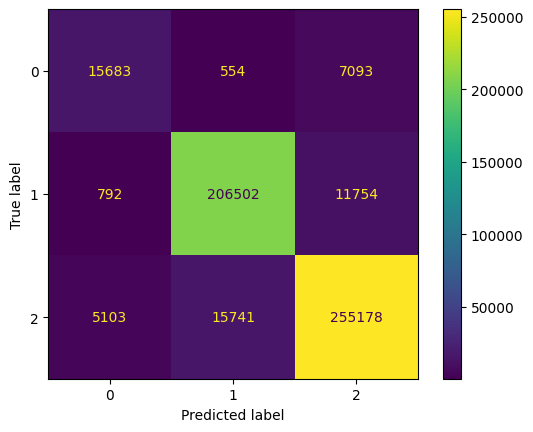

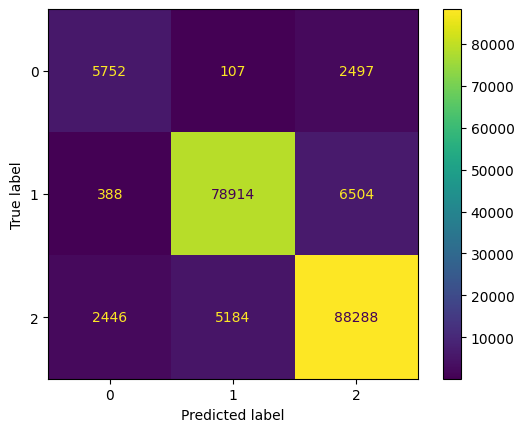

: 

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).detach().cpu(),yi.argmax(dim=1).detach().cpu()]).T for Xi,yi in trainloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).detach().cpu(),yi.argmax(dim=1).detach().cpu()]).T for Xi,yi in testloader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

In [ ]:
import numpy as np

validation_frequency_epochs = 1
best_dev_loss = torch.inf
best_dev_loss_epoch = 0
best_dev_f1 = 0
best_dev_f1_epoch = 0
ma_window_size = 10

model.to(device)
model.train()

trainlossi = []
testlossi = []
train_f1s = []
test_f1s = []

for epoch in range(1000):
    epoch_train_f1s = []  # Collect F1s for each batch in this epoch
    epoch_train_losses = []  # Collect losses for each batch in this epoch
    
    for Xi, yi in tqdm(trainloader):
        Xi, yi = Xi.to(device), yi.to(device)    
        logits = model(Xi)
        optimizer.zero_grad()
        loss = criterion(logits, yi)
        loss.backward()
        optimizer.step()
        
        # Calculate and store F1 for this batch
        batch_f1 = calculate_f1(logits, yi)
        epoch_train_f1s.append(batch_f1)
        epoch_train_losses.append(loss.item())
    
    # Add average loss and F1 for this epoch
    trainlossi.extend(epoch_train_losses)
    train_f1s.append(np.mean(epoch_train_f1s))
    
    if epoch % validation_frequency_epochs == 0:
        model.eval()
        all_test_preds = []
        all_test_labels = []
        test_losses = []

        with torch.no_grad():
            for Xi, yi in testloader:
                Xi, yi = Xi.to(device), yi.to(device)
                logits = model(Xi)
                loss = criterion(logits, yi)
                test_losses.append(loss.item())
                all_test_preds.append(logits.argmax(dim=1))
                all_test_labels.append(yi.argmax(dim=1))
            all_test_preds = torch.cat(all_test_preds).cpu()
            all_test_labels = torch.cat(all_test_labels).cpu()
            avg_test_loss = np.mean(test_losses)
            test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')

            testlossi.append(avg_test_loss)
            test_f1s.append(test_f1)

            # Track best model by loss
            if avg_test_loss < best_dev_loss:
                best_dev_loss = avg_test_loss
                best_dev_loss_epoch = epoch
                torch.save(model.state_dict(), 'best_model_by_loss.pt')
                
            # Track best model by F1
            if test_f1 > best_dev_f1:
                best_dev_f1 = test_f1
                best_dev_f1_epoch = epoch
                torch.save(model.state_dict(), 'best_model_by_f1.pt')
                
            # Call the updated plotting function with both loss and F1 data
            plot_training_progress(
                trainlossi,
                testlossi,
                train_f1s,
                test_f1s,
                ma_window_size,
                'training_metrics.jpg'
            )
            print(f"Epoch {epoch}: Train Loss: {np.mean(epoch_train_losses):.4f}, Test Loss: {avg_test_loss:.4f}")
            print(f"Train F1: {train_f1s[-1]:.4f}, Test F1: {test_f1:.4f}")
            print(f"Best Test Loss: {best_dev_loss:.4f} (Epoch {best_dev_loss_epoch})")
            print(f"Best Test F1: {best_dev_f1:.4f} (Epoch {best_dev_f1_epoch})")